# Pipeline
### **NOTE 1**: 

We are using ready-to-use data that has already been through the pipeline.

Because of the time required to download, preprocess and train the models, the model here has already been trained and we are using the model predictions as saved in a zipfile in the `data` directory.

In order to run the pipeline end-to-end and reproduce the steps prior to this notebook, you will need to run the `run_demo.py` script in the `scripts/` directory.

#### The data:
Make sure you unzip the file `zip_data.zip`.

This will produce a folder `zip_data` which we will use as our base data directory. Remember, if you were to reproduce this analysis by running the pipeline from end-to-end then you would simply use the default data directory at `.data`.

Inside `data/zip_data` we have two directories. **`features`** and **`models`**.

**`features`** contains the data that has been through the `preprocessors` and the `engineers`. It only contains data for the `test` set in order to reduce the memory requirements. 

**`models`** contains data that has been predicted by the given model. It also contains a saved version.

Here we only have two models: **`ealstm`** and **`previous_month`** which is our baseline model.

### **NOTE 2**:
Here the data only includes the baseline `persistence` model and the state of the art Entity Aware Long-Short Term Memory (EALSTM) network. See the `notebooks/docs/Pipeline.ipynb` notebook for more information about the other models that we currently accomodate.

## Making Predictions

We have a pretrained model in the zipped data directory. Here we will make the predictions with the **EALSTM** model and the baseline **persistence** model.

In [122]:
from src.models import load_model, Persistence

In [123]:
# make predictions and save results to .nc with BASELINE model
persistence = Persistence(data_folder=data_dir)
persistence.evaluate()

RMSE: 16.653808601170777


In [126]:
ealstm_path = data_dir / 'models/one_month_forecast/ealstm/model_gcloud.pt'
assert ealstm_path.exists(), \
    'Expected the unzipped file to have the model.pt file saved'

ealstm = load_model(model_path=ealstm_path)

In [127]:
# have to specify the ignore_vars is empty 
ealstm.ignore_vars = []
ealstm.evaluate(
    save_results=True,
    save_preds=False,
)

RMSE: 40.941688537597656


/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/xarray/coding/times.py:244: FutureWarning: the 'box' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'box'
  dates = pd.to_datetime(dates, box=False)


# evaluating the model

In [131]:
scores = annual_scores(
    data_path=data_dir,
    models=['ealstm', 'previous_month'],
    metrics=['rmse', 'r2'],
    verbose=False,
    to_dataframe=True
)

display(scores.head())

,month,ealstm,previous_month,metric
0,1.0,11.962646,15.918060,rmse
1,2.0,55.521111,9.609800,rmse
2,3.0,50.634243,18.995626,rmse
3,4.0,39.116074,24.495406,rmse
4,5.0,37.968170,18.025452,rmse


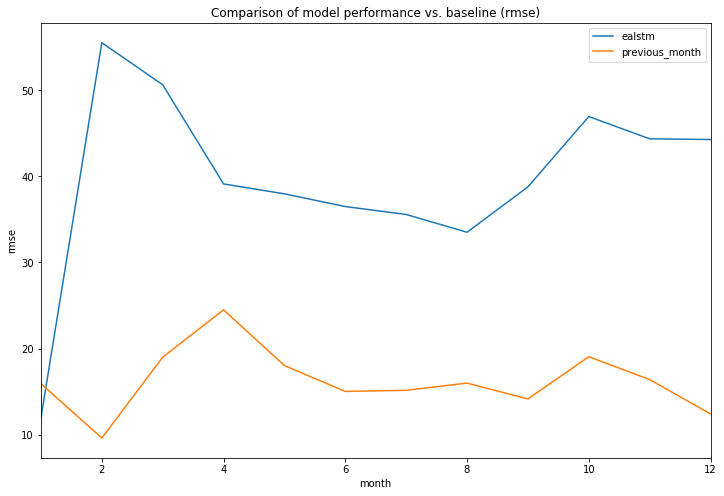

In [132]:
metric = 'rmse'
fig, ax = plt.subplots(figsize=(12, 8))
scores.loc[scores.metric == metric].plot(x='month', ax=ax)
ax.set_ylabel(metric)
ax.set_title(f'Comparison of model performance vs. baseline ({metric})');

In [52]:
# create long format dataframe
scores_long = pd.melt(
    scores, id_vars=['month', 'metric'], 
    value_vars=['ealstm', 'previous_month']
)
# get the separate metrics for plotting
rmse = scores_long.loc[scores_long.metric=='rmse']
r2 = scores_long.loc[scores_long.metric=='r2']

scores_long.head()

,month,metric,variable,value
0,1.0,rmse,ealstm,12.328923
1,2.0,rmse,ealstm,10.038730
2,3.0,rmse,ealstm,15.299802
3,4.0,rmse,ealstm,15.628013
4,5.0,rmse,ealstm,21.278271


Text(0.5, 1, 'RMSE Comparison for EALSTM vs. Baseline')

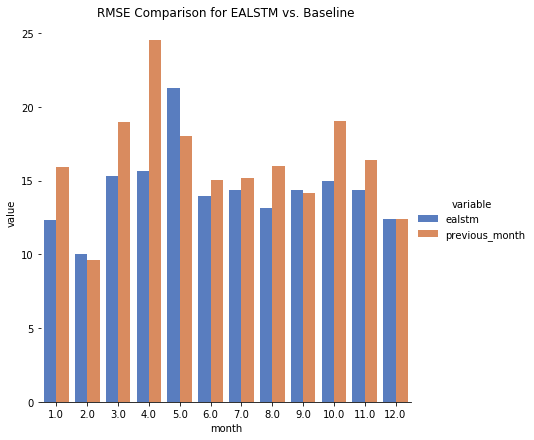

In [51]:
import seaborn as sns

g = sns.catplot(x="month", y="value", hue="variable", data=rmse,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
ax = plt.gca()
ax.set_title('RMSE Comparison for EALSTM vs. Baseline');

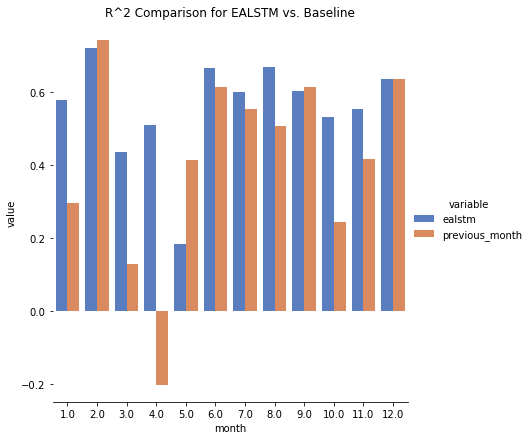

In [66]:
g = sns.catplot(x="month", y="value", hue="variable", data=r2,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
ax = plt.gca()
ax.set_title('R^2 Comparison for EALSTM vs. Baseline');

# Shap values

In [ ]:
input_pred_months

In [215]:
latitudes = latlons[:, 0]
longitudes = latlons[:, 1]
dims = ['lat', 'lon']
coords = {'lat': latitudes,
          'lon': longitudes}

xr.Dataset({'shap': (dims, values)}, coords=coords)


NameError: name 'variable_naems' is not defined